In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [4]:
#Used to split data into training and testing data
from sklearn.model_selection import train_test_split

# fit Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Easy Ensemble AdaBoost Classifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier

# Read the CSV and Perform Basic Data Cleaning

In [5]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [7]:
# Create our features
X = df.drop(columns='loan_status')
X = pd.get_dummies(X)

# Create our target
y = df['loan_status']

In [8]:
# Show the Describe details of X
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [9]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [11]:
# Resample the training data with the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(min_samples_leaf=2, n_jobs=1, random_state=1)

In [12]:
# Display the confusion matrix
y_pred_rf = brf.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[   57,    30],
       [ 1368, 15750]])

#### Translation for results above:

|                      |   **Predicted True**   |   **Predicted False**   |
|   :--------------    |   :----------------:   |   :-----------------:   |
|   **Actual True**    |   TP                   |   FN                    |
|   **Actual False**   |   FP                   |   TN                    |

In [13]:
# Calculate the Balanced Accuracy Score
balanced_accuracy_score(y_test, y_pred_rf)

0.787628267884985

In [14]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.66      0.92      0.08      0.78      0.59        87
   low_risk       1.00      0.92      0.66      0.96      0.78      0.62     17118

avg / total       0.99      0.92      0.66      0.95      0.78      0.62     17205



In [15]:
# Random Forests in sklearn will automatically calculate feature importance
importances = brf.feature_importances_
importances

array([0.01303984, 0.0249835 , 0.01714066, 0.01941774, 0.01680305,
       0.00410177, 0.00406494, 0.00750372, 0.00080997, 0.0143197 ,
       0.01108849, 0.01516491, 0.01612903, 0.05854891, 0.06904406,
       0.0832218 , 0.05353335, 0.0049577 , 0.        , 0.        ,
       0.06111999, 0.        , 0.        , 0.        , 0.00353353,
       0.01499814, 0.00566109, 0.00659243, 0.00461349, 0.00583636,
       0.0126969 , 0.01260647, 0.01270084, 0.00278991, 0.00494453,
       0.01630031, 0.01156652, 0.01300994, 0.00655735, 0.00896355,
       0.00902615, 0.00778038, 0.01239589, 0.01472807, 0.01557974,
       0.        , 0.        , 0.01372234, 0.01077464, 0.00918385,
       0.00597316, 0.00507887, 0.01261305, 0.0193612 , 0.00235358,
       0.00873342, 0.0089961 , 0.00766949, 0.00729374, 0.0078416 ,
       0.00932813, 0.01116757, 0.01017673, 0.00969549, 0.        ,
       0.        , 0.00028534, 0.00739129, 0.01098395, 0.0082931 ,
       0.00142111, 0.        , 0.0141081 , 0.0162305 , 0.01369

In [16]:
# List the features sorted in descending order by featuer importance
importances_df = pd.DataFrame(sorted(zip(brf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

# Show all rows
pd.set_option('display.max_rows', 100)

# Show DataFrame
importances_df

,Feature Importances
1,
total_rec_prncp,0.083222
total_pymnt_inv,0.069044
last_pymnt_amnt,0.061120
total_pymnt,0.058549
total_rec_int,0.053533
int_rate,0.024983
issue_d_Jan-2019,0.019778
annual_inc,0.019418
mths_since_recent_inq,0.019361


In [17]:
# Sort importances
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
importances_sorted.head()

,Feature Importances
1,
total_rec_prncp,0.083222
total_pymnt_inv,0.069044
last_pymnt_amnt,0.061120
total_pymnt,0.058549
total_rec_int,0.053533


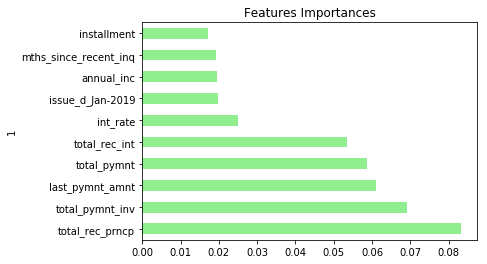

In [18]:
# Draw a horizontal barplot of top 10 importances_sorted
importances_sorted[0:10].plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


### Easy Ensemble AdaBoost Classifier

In [19]:
# Train using EasyEnsembleClassifier
eec = EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
            random_state=1, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, n_jobs=1, random_state=1)

In [20]:
# Display the confusion matrix
y_pred_eec = eec.predict(X_test)
confusion_matrix(y_test, y_pred_eec)

array([[   79,     8],
       [  979, 16139]])

#### Translation for results above:

|                      |   **Predicted True**   |   **Predicted False**   |
|   :--------------    |   :----------------:   |   :-----------------:   |
|   **Actual True**    |   TP                   |   FN                    |
|   **Actual False**   |   FP                   |   TN                    |

In [21]:
# Calculate the Balanced Accuracy Score
balanced_accuracy_score(y_test, y_pred_eec)

0.925427358175101

In [22]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.07      0.91      0.94      0.14      0.93      0.85        87
   low_risk       1.00      0.94      0.91      0.97      0.93      0.86     17118

avg / total       0.99      0.94      0.91      0.97      0.93      0.86     17205



### Easy Ensemble AdaBoost Classifier Take 2

In [23]:
# Train using AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=None, n_estimators=100,
            random_state=1,
            )
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=1)

In [24]:
# Display the confusion matrix
y_pred_ada = ada.predict(X_test)
confusion_matrix(y_test, y_pred_ada)

array([[   33,    54],
       [    6, 17112]])

In [25]:
# Calculate the Balanced Accuracy Score
balanced_accuracy_score(y_test, y_pred_ada)

0.6894799182953213

In [26]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_ada))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.85      0.38      1.00      0.52      0.62      0.36        87
   low_risk       1.00      1.00      0.38      1.00      0.62      0.40     17118

avg / total       1.00      1.00      0.38      1.00      0.62      0.40     17205

